In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import Voronoi, voronoi_plot_2d
import time
import statsmodels.api as sm

In [2]:
#set overall plot params
import matplotlib.pyplot as plt 
plt.rc('text', usetex=True)
plt.rc('font', family='Serif')

import matplotlib as mpl 
mpl.rcParams['figure.figsize'] = [10, 7]
mpl.rcParams['font.size'] = 27

mpl.rcParams['savefig.dpi'] = 150 
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['xtick.major.size'] = 10 
mpl.rcParams['xtick.minor.size'] = 5 

mpl.rcParams['ytick.major.size'] = 10 
mpl.rcParams['ytick.minor.size'] = 5 

mpl.rcParams['xtick.labelsize'] = 23
mpl.rcParams['ytick.labelsize'] = 23

In [3]:
M92_path = '/home/mying/Desktop/M92_data/'

In [105]:
#read empirical chi2
combined_std = 39
combined_mean = 3712

In [106]:
#fix to the best fit distance and reddening
DM_fit = 14.71
Red_fit = 0.0

In [107]:
#read chi2 results
os.chdir(M92_path + 'outchi2')
test_chi2_in_range = np.array([])
for file in os.listdir():
    dp = pd.read_csv(file)
    dp_fit = dp[(dp['dm'] == DM_fit) & (dp['red'] == Red_fit) & (dp['chi2'] <= combined_mean + 5*combined_std)]
    if len(dp_fit) != 0:
        dp_fit['MCnumber'] = int(file[2:])
        if len(test_chi2_in_range) == 0:
            test_chi2_in_range = dp_fit.to_numpy()
        else:
            test_chi2_in_range = np.concatenate((test_chi2_in_range,dp_fit.to_numpy()),axis=0)

/tmp/ipykernel_7472/947304589.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dp_fit['MCnumber'] = int(file[2:])
/tmp/ipykernel_7472/947304589.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dp_fit['MCnumber'] = int(file[2:])
/tmp/ipykernel_7472/947304589.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

In [109]:
#read calibration star test results
dp = pd.read_csv(M92_path + 'mccdf_full.csv')
cdf = []
for i in range(len(test_chi2_in_range)):
#    if test_chi2_in_range[i][3] < combined_mean:
#        cdf.append(1)
#    else:
    for j in range(len(dp)):
        if dp['MCnumber'].values[j] == int(test_chi2_in_range[i][4]):
            cdf.append(1 - dp['cdf'].values[j])
total_pt = 0
for file in test_chi2_in_range:
    if file[3] >= np.mean(combined_mean):
        total_pt += 1
density = np.linspace(1,total_pt,total_pt)/total_pt

In [108]:
len(test_chi2_in_range)

230

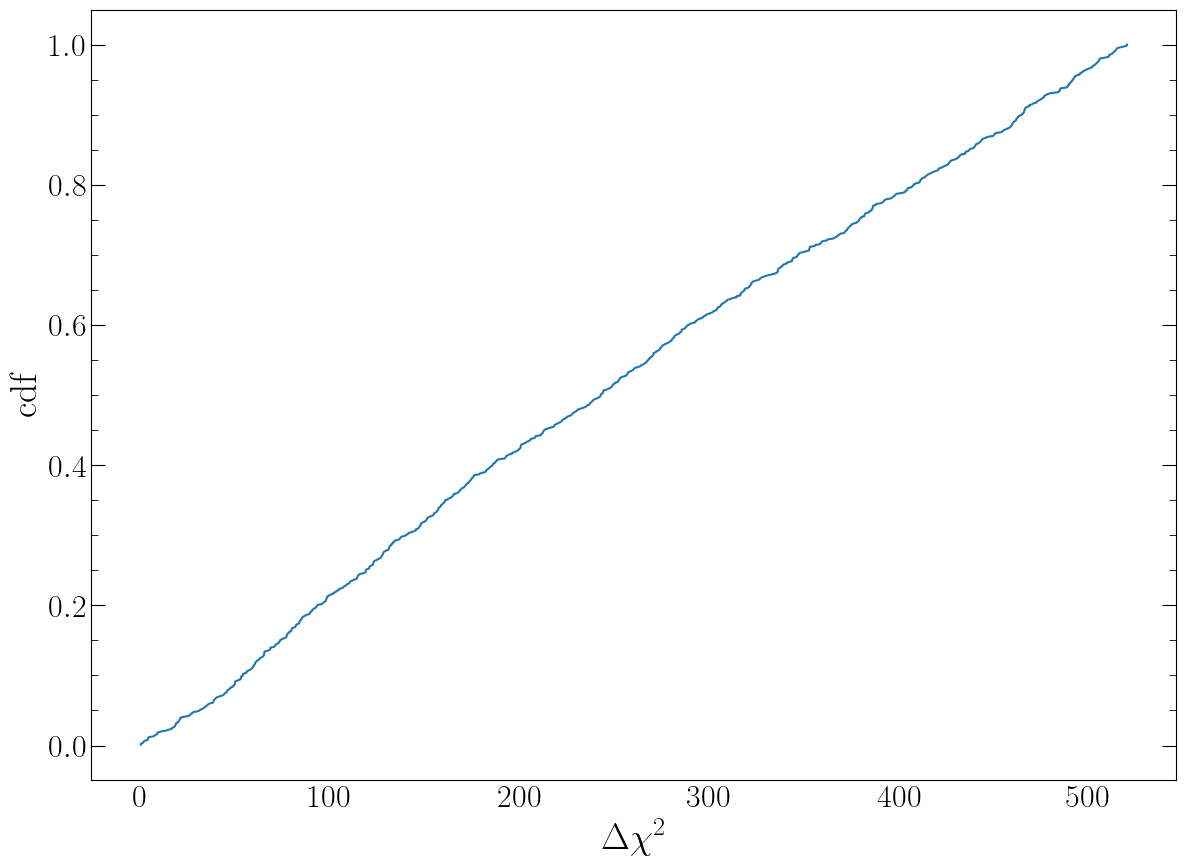

In [145]:
#plot chi2 distribition
chi2 = np.array(test_chi2_in_range)[:,3]
chi2 = np.sort(chi2.astype(float))
chi2 = chi2[chi2 >= np.mean(combined_mean)]
plt.plot(chi2 - np.mean(combined_mean),density)
plt.xlabel("$\Delta \chi^2$")
plt.ylabel('cdf')
plt.tick_params(axis='x',direction="in")
plt.tick_params(axis='y',direction="in")
#plt.savefig(M92_path + 'plots\\delta_chi2.pdf', dpi=150);

In [111]:
#calculate weight for each iso
weight = []
for i in range(len(test_chi2_in_range)):
    if test_chi2_in_range[i][3] <= combined_mean:
        weight.append(cdf[i])
    else:
        for j in range(len(chi2)):
            if chi2[j] == test_chi2_in_range[i][3]:
                weight.append(cdf[i]*(1 - density[j]))

In [112]:
#find age and std
import math
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights,axis=0)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))
average, std = weighted_avg_and_std(test_chi2_in_range[:,0],np.array(weight))

In [113]:
print(average,std)

13837.137279495491 485.9845170714996


In [114]:
#read all the var files
os.chdir(M92_path + 'var')
var = []
for i in range(len(test_chi2_in_range)):
    dp = pd.read_fwf("newvarfeh230.{}".format(str(int(test_chi2_in_range[i,4]))),widths=[10,30],names=['value', 'name'])
    var.append(dp['value'].values)
var = np.array(var)

In [115]:
#prepare data
data = test_chi2_in_range
data[:,[0,1,2]] = data[:,[1,2,0]]
for i in range(len(data)):
    data[i,3] = weight[i]

In [116]:
#Read all var files
total_var = var.T[:-1].tolist()
#total_var.append(data[:,0].tolist())
#total_var.append(data[:,1].tolist())
total_var = np.array(total_var)

In [117]:
#generate covariance matrix
m_cov = np.cov(total_var, aweights=data[:,-1])

In [118]:
import statsmodels.api as sm

In [119]:
mod_wls = sm.WLS(data[:,2], np.vstack([total_var, np.ones(len(data))]).T, weights=data[:,-1])
res_wls = mod_wls.fit()
print(res_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.894
Model:                            WLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     87.68
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           5.17e-90
Time:                        14:47:20   Log-Likelihood:                -1496.1
No. Observations:                 230   AIC:                             3034.
Df Residuals:                     209   BIC:                             3106.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -3237.0232    167.082    -19.374      0.0

In [120]:
#find total variance
retval = 0
for i in range(len(res_wls.params) - 1):
    for j in range(len(res_wls.params) - 1):
        if i == j:
            retval += np.std(total_var.T[:,i])**2 *res_wls.params[i]**2
        else:
            retval += res_wls.params[i]*res_wls.params[j]*m_cov[i][j]
np.sqrt(retval)

463.34461811501546

In [ ]:
#total variance without correlation
retval = 0
for i in range(len(res_wls.params) - 1):
    for j in range(len(res_wls.params) - 1):
        if i == j:
            retval += np.std(total_var.T[:,i])**2 *res_wls.params[i]**2
        else:
            retval += 0
np.sqrt(retval)

In [121]:
#create lists of names and error greater than 5%
y = []
for i in range(20):
    y.append(np.abs(np.std(total_var.T[:,i]) *res_wls.params[i]/average *100))
y = np.array(y)
names = ['[Fe/H]','Primordial He', r"[$\alpha$/Fe]",'Mixing length','He diffusion', 'Heavy element diffusion','Surface boundary condition', 'Convective envelope overshoot', r'$p + p \to H_2 + e + \nu$', r'${ }^{3}He + { }^{3}He \to { }^{4}He + p + p$', r'${ }^{3}He + { }^{4}He \to { }^{2}H + \gamma$', r'${ }^{12}C + p \to { }^{13}N + \gamma$ ', r'${ }^{13}C + p \to { }^{14}N + \gamma$', r'${ }^{14}N + p \to { }^{15}O + \gamma$', r'${ }^{16}N + p \to { }^{17}F + \gamma$','Low T opacities', "High T opacities",r'Triple-$alpha$ coeff', 'Plasma neutrino loses', 'Conductive opacities']
others = 0
mask = []
for i in range(len(names)):
    if y[i] > 0.05:
#        print(names[i])
#        print(y[i])
        mask.append(i)
    else:
        others += y[i]**2
names_update = []
for i in mask:
    names_update.append(names[i])
names_update.append('Others')
y = y[mask].tolist()
y.append(np.sqrt(others))
y = np.array(y)

In [122]:
np.sqrt(retval)/average

0.033485583669218985

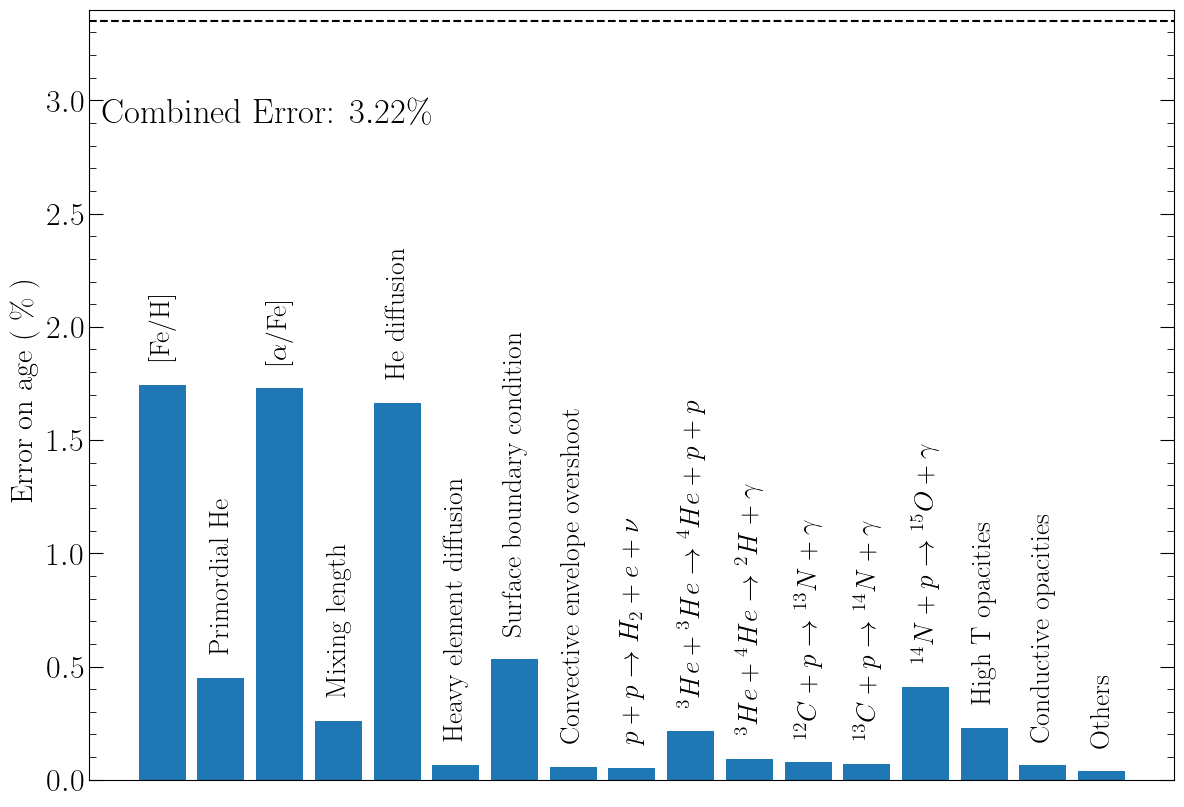

In [124]:
#Plot
from matplotlib.offsetbox import AnchoredText
mpl.rcParams['figure.figsize'] = [14, 10]
mpl.rcParams['xtick.major.size'] = 0
mpl.rcParams['xtick.minor.size'] = 0
#y = np.abs(np.array(ages) - average)/average*100
x = np.arange(17)
fig, ax2 = plt.subplots(1,1)
# plot the same data on both axes
ax2.bar(x, height=y)
ax2.axhline(y=np.sqrt(retval)/average*100,linestyle='--',c='black')
#ax2.legend(prop={'size': 18})
ax2.set_ylim(0.0, 3.4)  # outliers only
#ax2.axes.xaxis.set_visible(False)
#ax2.text(0.95, 0.95, r"$\textup{Combined Error:} 5.3\%$", transform=ax.transAxes, fontsize=14,verticalalignment='top')
txt = ax2.text(1.8, 2.9, r"$\textup{Combined Error: } 3.22\%$", size=25, ha="center", color="black")

#anchored_text = AnchoredText("Test", loc=2)
#ax2.add_artist(anchored_text)
ax2.axes.xaxis.set_ticklabels([])
#ax2.set_xticks(x)
#ax2.set_xticklabels(names,rotation='vertical',fontsize=10)
rects = ax2.patches
labels = names_update
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width() / 2, height+0.10, label,
            ha='center', va='bottom',rotation='vertical',fontsize=20)
# hide the spines between ax and ax2
ax2.xaxis.tick_top()
ax2.xaxis.tick_bottom()
ax2.set_ylabel(r'Error on age ( $\%$ )',fontsize=22)
ax2.yaxis.set_label_coords(0.09, 0.5, transform=fig.transFigure)
#plt.savefig(M92_path + 'plots/error_budget.png', dpi=300)
plt.show();

In [ ]:
average, std = weighted_avg_and_std(test_chi2_in_range[:,2],np.array(weight))
#bins = np.linspace(11.7999,15.7999,21).tolist()
#bins.append(16.0001)
#bins = np.array(bins)
plt.hist(test_chi2_in_range[:,2]/1000,weights=weight,density=True)#,bins = bins)
#x_axis = np.linspace(11.6,16.2,240)
#plt.plot(x_axis, norm.pdf(x_axis, average/1000, std/1000),'--',label='Best-fit Gaussian')
#plt.errorbar(average/1000, 0.3, xerr=np.array([[average/1000 - 12400/1000], [15400/1000 - average/1000]]),capsize=5,label=r"95 \% CI",c='r')
#plt.scatter(average/1000, 0.3,s=50,c='r')
plt.xlabel('Age (Gyr)')
plt.ylabel('Density')
plt.legend(fontsize=18)
#plt.savefig(M92_path + 'plots\\Age_distribution.pdf', dpi=300);

In [62]:
#fix to the best fit distance and reddening
DM_fit = 14.82
Red_fit = 0.0
#read chi2 results
os.chdir(M92_path + 'outchi2')
test_chi2_in_range = np.array([])
for file in os.listdir():
    dp = pd.read_csv(file)
    #dp_fit = dp[(dp['dm'] == DM_fit) & (dp['red'] == Red_fit) & (dp['chi2'] <= combined_mean + 5*combined_std)]
    dp_fit = dp[(dp['dm'] == DM_fit) & (dp['chi2'] <= combined_mean + 5*combined_std)]
    if len(dp_fit) != 0:
        dp_fit['MCnumber'] = int(file[2:])
        if len(test_chi2_in_range) == 0:
            test_chi2_in_range = dp_fit.to_numpy()
        else:
            test_chi2_in_range = np.concatenate((test_chi2_in_range,dp_fit.to_numpy()),axis=0)
#read calibration star test results
dp = pd.read_csv(M92_path + 'mccdf_full.csv')
cdf = []
for i in range(len(test_chi2_in_range)):
#    if test_chi2_in_range[i][3] < combined_mean:
#        cdf.append(1)
#    else:
    for j in range(len(dp)):
        if dp['MCnumber'].values[j] == int(test_chi2_in_range[i][4]):
            cdf.append(1 - dp['cdf'].values[j])
total_pt = 0
for file in test_chi2_in_range:
    if file[3] >= np.mean(combined_mean):
        total_pt += 1
density = np.linspace(1,total_pt,total_pt)/total_pt
chi2 = np.array(test_chi2_in_range)[:,3]
chi2 = np.sort(chi2.astype(float))
chi2 = chi2[chi2 >= np.mean(combined_mean)]
#calculate weight for each iso
weight = []
for i in range(len(test_chi2_in_range)):
    if test_chi2_in_range[i][3] <= combined_mean:
        weight.append(cdf[i])
    else:
        for j in range(len(chi2)):
            if chi2[j] == test_chi2_in_range[i][3]:
                weight.append(cdf[i]*(1 - density[j]))
#find age and std
import math
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights,axis=0)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))
average, std = weighted_avg_and_std(test_chi2_in_range[:,0],np.array(weight))
#read all the var files
os.chdir(M92_path + 'var')
var = []
for i in range(len(test_chi2_in_range)):
    dp = pd.read_fwf("newvarfeh230.{}".format(str(int(test_chi2_in_range[i,4]))),widths=[10,30],names=['value', 'name'])
    var.append(dp['value'].values)
var = np.array(var)
#prepare data
data = test_chi2_in_range
data[:,[0,1,2]] = data[:,[1,2,0]]
for i in range(len(data)):
    data[i,3] = weight[i]
#Read all var files
total_var = var.T[:-1].tolist()
total_var.append(data[:,0].tolist())
total_var.append(data[:,1].tolist())
total_var = np.array(total_var)
#generate covariance matrix
m_cov = np.cov(total_var, aweights=data[:,-1])
mod_wls = sm.WLS(data[:,2], np.vstack([total_var, np.ones(len(data))]).T, weights=data[:,-1])
res_wls = mod_wls.fit()
print(res_wls.summary())

/tmp/ipykernel_7472/1238141568.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dp_fit['MCnumber'] = int(file[2:])
/tmp/ipykernel_7472/1238141568.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dp_fit['MCnumber'] = int(file[2:])
/tmp/ipykernel_7472/1238141568.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.886
Model:                            WLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     68.01
Date:                Thu, 08 Jun 2023   Prob (F-statistic):           4.11e-75
Time:                        13:55:54   Log-Likelihood:                -1304.2
No. Observations:                 206   AIC:                             2652.
Df Residuals:                     184   BIC:                             2726.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2819.5844    150.975    -18.676      0.0

In [63]:
len(test_chi2_in_range)

206

In [64]:
#find total variance
retval = 0
for i in range(len(res_wls.params) - 1):
    for j in range(len(res_wls.params) - 1):
        if i == j:
            retval += np.std(total_var.T[:,i])**2 *res_wls.params[i]**2
        else:
            retval += res_wls.params[i]*res_wls.params[j]*m_cov[i][j]
std = np.sqrt(retval)
print(std,std/average)

374.87866009028716 0.02925647681749384


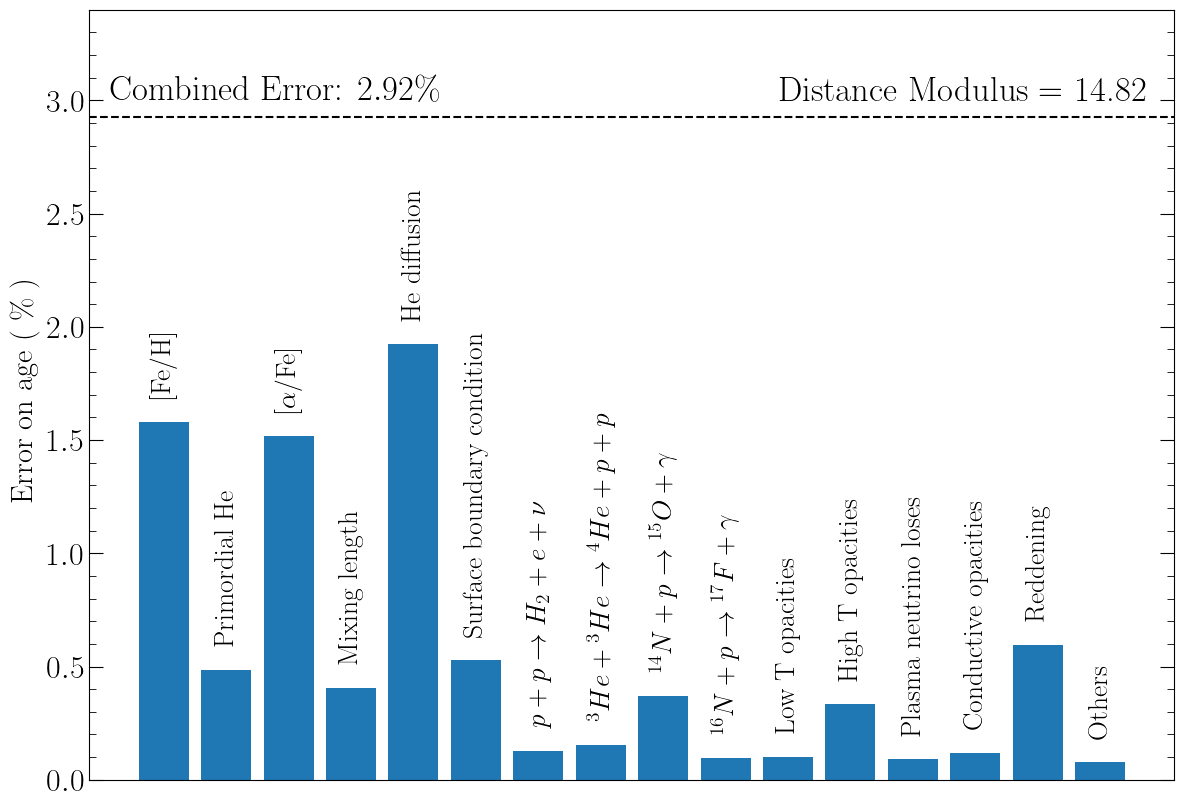

In [71]:
#create lists of names and error greater than 5%
y = []
for i in range(22):
    y.append(np.abs(np.std(total_var.T[:,i]) *res_wls.params[i]/average *100))
y = np.array(y)
names = ['[Fe/H]','Primordial He', r"[$\alpha$/Fe]",'Mixing length','He diffusion', 'Heavy element diffusion','Surface boundary condition', 'Convective envelope overshoot', r'$p + p \to H_2 + e + \nu$', r'${ }^{3}He + { }^{3}He \to { }^{4}He + p + p$', r'${ }^{3}He + { }^{4}He \to { }^{2}H + \gamma$', r'${ }^{12}C + p \to { }^{13}N + \gamma$ ', r'${ }^{13}C + p \to { }^{14}N + \gamma$', r'${ }^{14}N + p \to { }^{15}O + \gamma$', r'${ }^{16}N + p \to { }^{17}F + \gamma$','Low T opacities', "High T opacities",r'Triple-$alpha$ coeff', 'Plasma neutrino loses', 'Conductive opacities','Distance','Reddening']
others = 0
mask = []
for i in range(len(names)):
    if y[i] > 0.05:
#        print(names[i])
#        print(y[i])
        mask.append(i)
    else:
        others += y[i]**2
names_update = []
for i in mask:
    names_update.append(names[i])
names_update.append('Others')
y = y[mask].tolist()
y.append(np.sqrt(others))
y = np.array(y)
#Plot
from matplotlib.offsetbox import AnchoredText
mpl.rcParams['figure.figsize'] = [14, 10]
mpl.rcParams['xtick.major.size'] = 0
mpl.rcParams['xtick.minor.size'] = 0
#y = np.abs(np.array(ages) - average)/average*100
x = np.arange(16)
fig, ax2 = plt.subplots(1,1)
# plot the same data on both axes
ax2.bar(x, height=y)
ax2.axhline(y=np.sqrt(retval)/average*100,linestyle='--',c='black')
#ax2.legend(prop={'size': 18})
ax2.set_ylim(0.0, 3.4)  # outliers only
#ax2.axes.xaxis.set_visible(False)
#ax2.text(0.95, 0.95, r"$\textup{Combined Error:} 5.3\%$", transform=ax.transAxes, fontsize=14,verticalalignment='top')
txt = ax2.text(1.8, 3.0, r"$\textup{Combined Error: } 2.92\%$", size=25, ha="center", color="black")
txt = ax2.text(12.8, 3.0, "Distance Modulus = {}".format(DM_fit), size=25, ha="center", color="black")

#anchored_text = AnchoredText("Test", loc=2)
#ax2.add_artist(anchored_text)
ax2.axes.xaxis.set_ticklabels([])
#ax2.set_xticks(x)
#ax2.set_xticklabels(names,rotation='vertical',fontsize=10)
rects = ax2.patches
labels = names_update
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width() / 2, height+0.10, label,
            ha='center', va='bottom',rotation='vertical',fontsize=20)
# hide the spines between ax and ax2
ax2.xaxis.tick_top()
ax2.xaxis.tick_bottom()
ax2.set_ylabel(r'Error on age ( $\%$ )',fontsize=22)
ax2.yaxis.set_label_coords(0.09, 0.5, transform=fig.transFigure)
plt.savefig(M92_path + 'plots/error_budget_dm_14_dot_82.png', dpi=300)
plt.show();

In [76]:
os.chdir(M92_path + 'outchi2')
test_chi2_in_range_fit = np.array([])
for file in os.listdir():
    dp = pd.read_csv(file)
    dp_fit = dp[(dp['dm'] == DM_fit) & (dp['red'] == Red_fit) & (dp['chi2'] <= combined_mean + 5*combined_std)]
    if len(dp_fit) != 0:
        dp_fit['MCnumber'] = int(file[2:])
        if len(test_chi2_in_range_fit) == 0:
            test_chi2_in_range_fit = dp_fit.to_numpy()
        else:
            test_chi2_in_range_fit = np.concatenate((test_chi2_in_range_fit,dp_fit.to_numpy()),axis=0)
#read calibration star test results
dp = pd.read_csv(M92_path + 'mccdf_full.csv')
cdf = []
for i in range(len(test_chi2_in_range_fit)):
#    if test_chi2_in_range[i][3] < combined_mean:
#        cdf.append(1)
#    else:
    for j in range(len(dp)):
        if dp['MCnumber'].values[j] == int(test_chi2_in_range_fit[i][4]):
            cdf.append(1 - dp['cdf'].values[j])
total_pt = 0
for file in test_chi2_in_range_fit:
    if file[3] >= np.mean(combined_mean):
        total_pt += 1
density = np.linspace(1,total_pt,total_pt)/total_pt
chi2 = np.array(test_chi2_in_range_fit)[:,3]
chi2 = np.sort(chi2.astype(float))
chi2 = chi2[chi2 >= np.mean(combined_mean)]
#calculate weight for each iso
weight_fit = []
for i in range(len(test_chi2_in_range_fit)):
    if test_chi2_in_range_fit[i][3] <= combined_mean:
        weight_fit.append(cdf[i])
    else:
        for j in range(len(chi2)):
            if chi2[j] == test_chi2_in_range_fit[i][3]:
                weight_fit.append(cdf[i]*(1 - density[j]))

/tmp/ipykernel_7472/3194709616.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dp_fit['MCnumber'] = int(file[2:])
/tmp/ipykernel_7472/3194709616.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dp_fit['MCnumber'] = int(file[2:])
/tmp/ipykernel_7472/3194709616.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

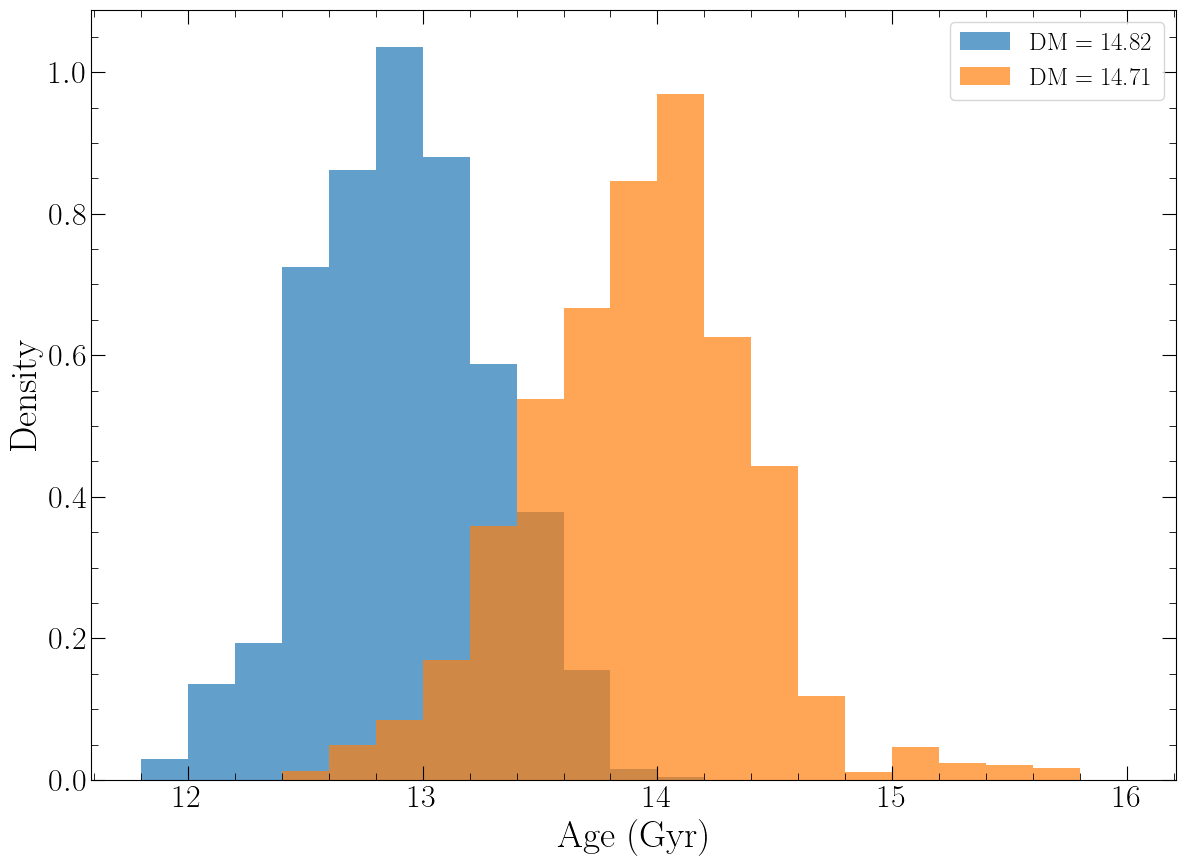

In [83]:
mpl.rcParams['figure.figsize'] = [14, 10]
mpl.rcParams['font.size'] = 27

mpl.rcParams['savefig.dpi'] = 150 
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['xtick.major.size'] = 10 
mpl.rcParams['xtick.minor.size'] = 5 

mpl.rcParams['ytick.major.size'] = 10 
mpl.rcParams['ytick.minor.size'] = 5 

mpl.rcParams['xtick.labelsize'] = 23
mpl.rcParams['ytick.labelsize'] = 23
average, std = weighted_avg_and_std(test_chi2_in_range[:,2],np.array(weight))
bins = np.linspace(11.7999,15.7999,21).tolist()
bins.append(16.0001)
bins = np.array(bins)
plt.hist(test_chi2_in_range[:,2]/1000,weights=weight,density=True, bins = bins,alpha=0.7,label='DM = 14.82')
plt.hist(test_chi2_in_range_fit[:,0]/1000,weights=weight_fit,density=True, bins = bins,alpha=0.7,label='DM = 14.71')
#x_axis = np.linspace(11.6,16.2,240)
#plt.plot(x_axis, norm.pdf(x_axis, average/1000, std/1000),'--',label='Best-fit Gaussian')
#plt.errorbar(average/1000, 0.3, xerr=np.array([[average/1000 - 12400/1000], [15400/1000 - average/1000]]),capsize=5,label=r"95 \% CI",c='r')
#plt.scatter(average/1000, 0.3,s=50,c='r')
plt.xlabel('Age (Gyr)')
plt.ylabel('Density')
plt.legend(fontsize=18)
plt.savefig(M92_path + 'plots/age_distribution.png', dpi=300)

In [78]:
test_chi2_in_range_fit

array([[1.38000000e+04, 1.47100000e+01, 0.00000000e+00, 3.78161547e+03,
        1.09910000e+04],
       [1.40000000e+04, 1.47100000e+01, 0.00000000e+00, 4.13676416e+03,
        1.09910000e+04],
       [1.28000000e+04, 1.47100000e+01, 0.00000000e+00, 3.90080086e+03,
        1.23040000e+04],
       ...,
       [1.36000000e+04, 1.47100000e+01, 0.00000000e+00, 3.80835072e+03,
        1.18300000e+04],
       [1.40000000e+04, 1.47100000e+01, 0.00000000e+00, 3.22718651e+03,
        1.98600000e+04],
       [1.42000000e+04, 1.47100000e+01, 0.00000000e+00, 3.68332199e+03,
        1.98600000e+04]])

In [129]:
#read chi2 results
os.chdir(M92_path + 'outchi2')
test_chi2_in_range = np.array([])
count = 0
for file in os.listdir():
    dp = pd.read_csv(file)
    #dp_fit = dp[(dp['dm'] == DM_fit) & (dp['red'] == Red_fit) & (dp['chi2'] <= combined_mean + 5*combined_std)]
    dp_fit = dp[dp['chi2'] <= combined_mean + 5*combined_std].sort_values(by='chi2')
    if len(dp_fit) != 0:
        count += 1
        # dp_fit['MCnumber'] = int(file[2:])
        # if len(test_chi2_in_range) == 0:
        #     test_chi2_in_range = dp_fit.to_numpy()
        # else:
        #     test_chi2_in_range = np.concatenate((test_chi2_in_range,dp_fit.to_numpy()),axis=0)
count

660

In [149]:
#read chi2 results
os.chdir(M92_path + 'outchi2')
retval = 8234
test_chi2_less_4000 = np.array([])
for file in os.listdir()[:retval]:
    dp = pd.read_csv(file)
    for i in range(41):
        idx = dp.index[dp['chi2']==dp.loc[126*i:126*(i+1)].min(axis=0)[-1]]
        chi2 = dp['chi2'].values[idx]
        if chi2 < 4000:
            if len(test_chi2_less_4000) == 0:
                test_chi2_less_4000 = np.concatenate((dp.iloc[idx].values[0],np.array([int(file[-5:])])))
            else:
                test_chi2_less_4000 = np.concatenate((test_chi2_less_4000, np.concatenate((dp.iloc[idx].values[0],np.array([int(file[-5:])])))))

In [150]:
#find chi2 in range
result = []
for i in range(len(test_chi2_less_4000)):
    if i % 5 == 0:
        result.append(test_chi2_less_4000[i:i+5])
chi2_less_4000 = np.array(result)
test_chi2_in_range = chi2_less_4000[chi2_less_4000[:,3]<(combined_mean + combined_std * 5)]

In [151]:
len(test_chi2_in_range)

1100

ValueError: x and y must have same first dimension, but have shapes (597,) and (312,)

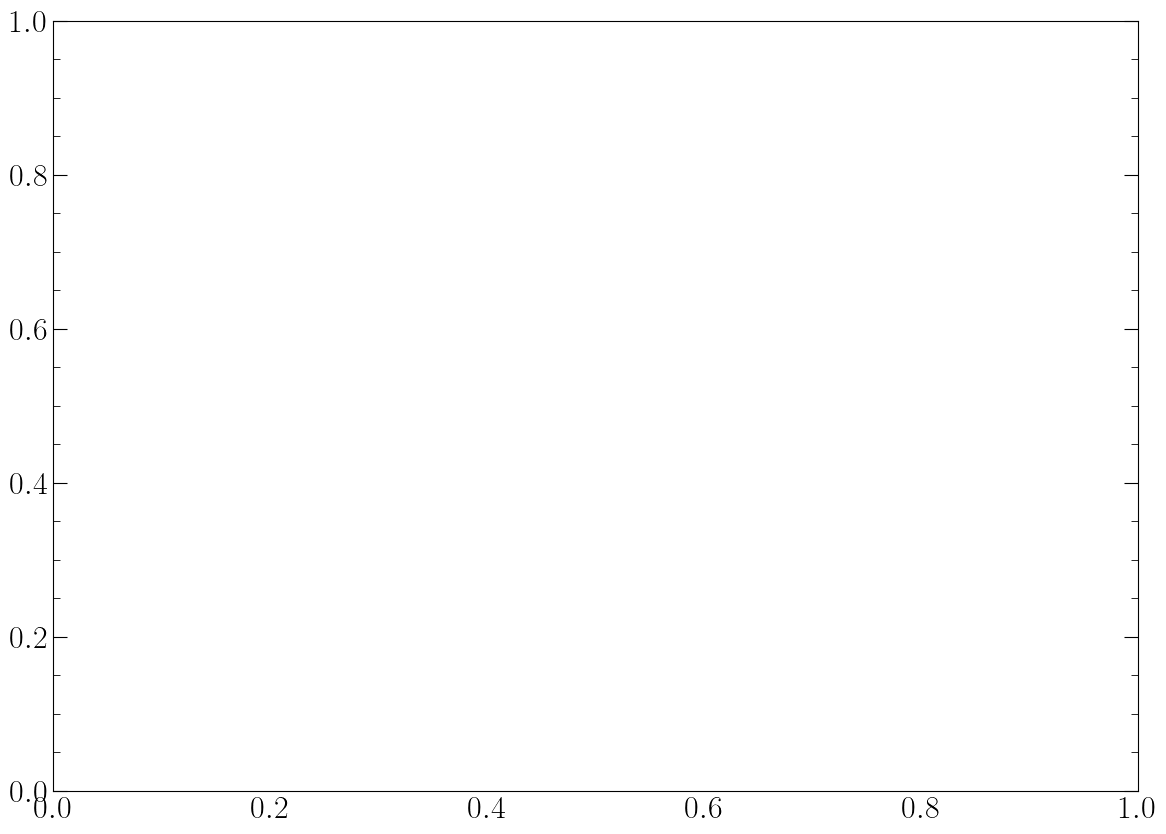

In [152]:
#plot chi2 distribition
chi2 = np.array(test_chi2_in_range)[:,3]
chi2 = np.sort(chi2.astype(float))
chi2 = chi2[chi2 >= np.mean(combined_mean)]
plt.plot(chi2 - np.mean(combined_mean),density)
plt.xlabel("$\Delta \chi^2$")
plt.ylabel('cdf')
plt.tick_params(axis='x',direction="in")
plt.tick_params(axis='y',direction="in")
#plt.savefig(M92_path + 'plots\\delta_chi2.pdf', dpi=150);

In [148]:
len(chi2)

312

In [142]:
test_chi2_in_range = test_chi2_in_range[test_chi2_in_range[:,3].argsort()]
test_chi2_in_range = test_chi2_in_range[:1100]

In [153]:
#read calibration star test results
dp = pd.read_csv(M92_path + 'mccdf_full.csv')
cdf = []
for i in range(len(test_chi2_in_range)):
#    if test_chi2_in_range[i][3] < combined_mean:
#        cdf.append(1)
#    else:
    for j in range(len(dp)):
        if dp['MCnumber'].values[j] == int(test_chi2_in_range[i][4]):
            cdf.append(1 - dp['cdf'].values[j])
total_pt = 0
for file in test_chi2_in_range:
    if file[3] >= np.mean(combined_mean):
        total_pt += 1
density = np.linspace(1,total_pt,total_pt)/total_pt
chi2 = np.array(test_chi2_in_range)[:,3]
chi2 = np.sort(chi2.astype(float))
chi2 = chi2[chi2 >= np.mean(combined_mean)]
#calculate weight for each iso
weight = []
for i in range(len(test_chi2_in_range)):
    if test_chi2_in_range[i][3] <= combined_mean:
        weight.append(cdf[i])
    else:
        for j in range(len(chi2)):
            if chi2[j] == test_chi2_in_range[i][3]:
                weight.append(cdf[i]*(1 - density[j]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


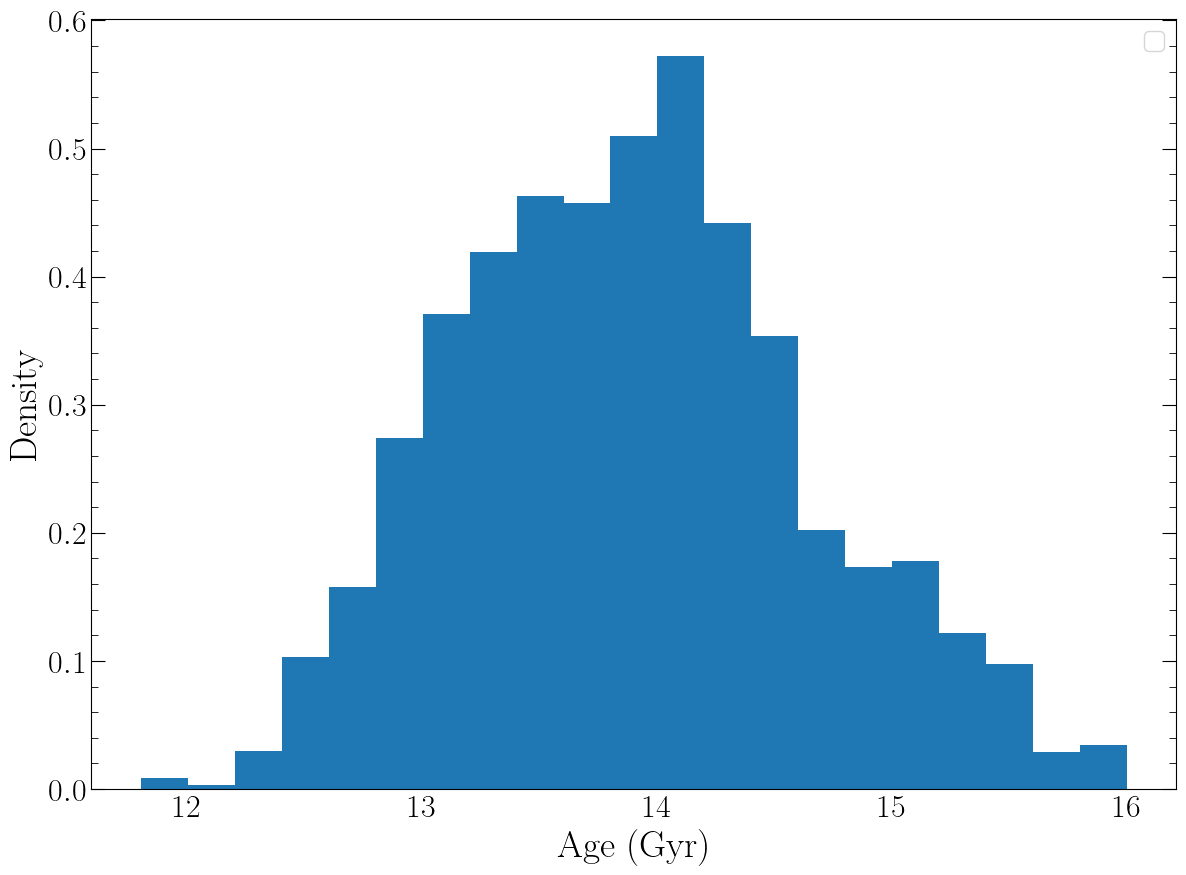

In [155]:
bins = np.linspace(11.7999,15.7999,21).tolist()
bins.append(16.0001)
bins = np.array(bins)
plt.hist(test_chi2_in_range[:,0]/1000,weights=weight,density=True, bins = bins)
#x_axis = np.linspace(11.6,16.2,240)
#plt.plot(x_axis, norm.pdf(x_axis, average/1000, std/1000),'--',label='Best-fit Gaussian')
#plt.errorbar(average/1000, 0.3, xerr=np.array([[average/1000 - 12400/1000], [15400/1000 - average/1000]]),capsize=5,label=r"95 \% CI",c='r')
#plt.scatter(average/1000, 0.3,s=50,c='r')
plt.xlabel('Age (Gyr)')
plt.ylabel('Density')
plt.legend(fontsize=18)
#plt.savefig(M92_path + 'plots/age_distribution.png', dpi=300)

In [157]:
test_chi2_in_range[:,0]

array([13200., 13800., 13800., ..., 14200., 13600., 12800.])

In [160]:
len(weight)

1100

In [162]:
d = {'Age (Gyr)': test_chi2_in_range[:,0]/1000, 'Weight': np.array(weight)}
df = pd.DataFrame(data=d)
df.to_csv("{}/Figure9_data.csv".format(M92_path),index=False)